# Testing STructured Additive REGression for nasty data distributions

- bulk data vs well-distributed data
- equidistant vs quantile based


## ToDo
- [x] Single point prediction
- [x] Extrapolation
- [x] Klemmen
- [x] Cost function partitioning
- [x] Multi-peak
- [x] Confidence Intervals
- [x] Prediction Intervals
- [ ] Data Preprocessing and Quality Check
- [ ] Fit Metric using Constraints

## IMPORTS

In [1]:
import numpy as np
import pandas as pd
import copy
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import ParameterGrid
from sklearn.utils import check_X_y 
from sklearn.metrics import mean_squared_error

from scipy.stats import t
from scipy.signal import find_peaks

from stareg.utils import check_constraint, test_model_against_constraint
from stareg import StarModel 
from stareg.utils import check_constraint_full_model, bar_chart_of_coefficient_difference_dataframe
from stareg import Smooths as s

## 1D Test Case

In [8]:
np.random.normal(size=10)

array([-0.11564828, -0.3011037 , -1.47852199, -0.71984421, -0.46063877,
        1.05712223,  0.34361829, -1.76304016,  0.32408397, -0.38508228])

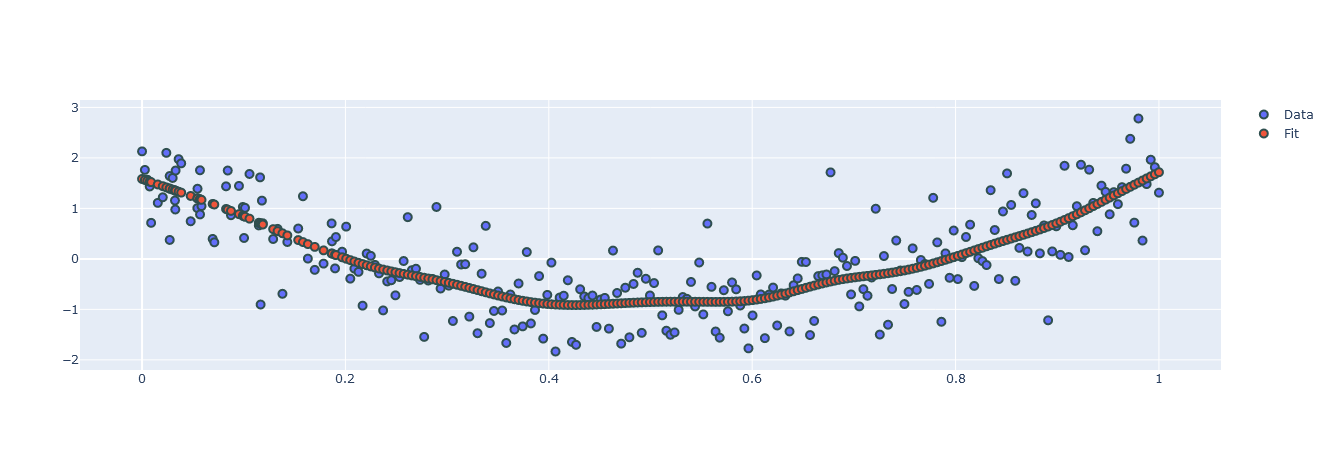

Violated Constraints: 1 from 35 
Metric =  0.38703
MSE =  0.3496239


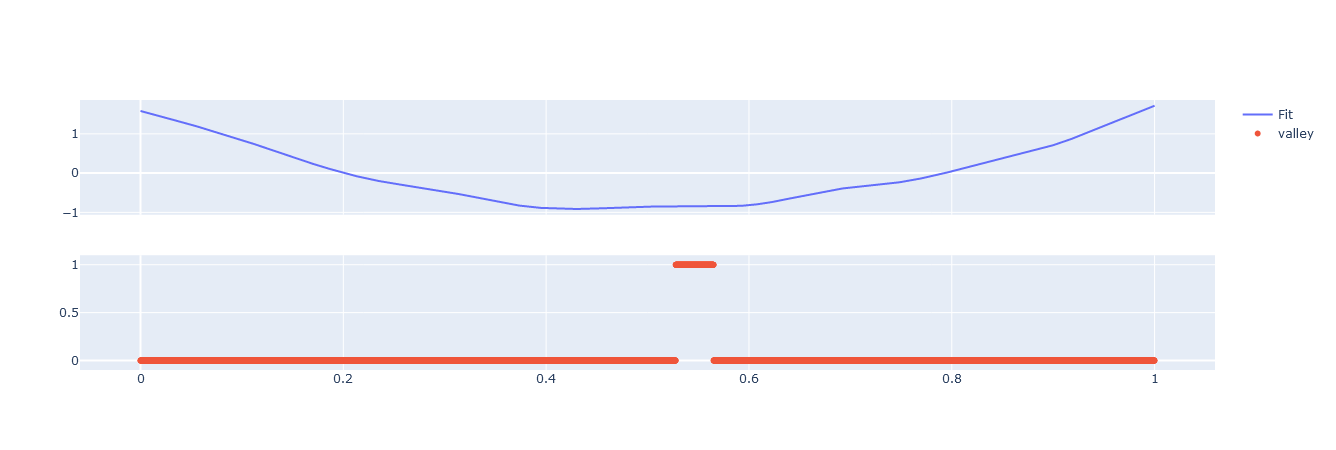

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
# try CV on 1-d dataset

# generate data
np.random.seed(42)
x_dense = np.random.random(50) * 0.2
x_sparse = np.linspace(0.2,1,200)
x_dense.sort()
x=np.concatenate((x_dense, x_sparse))
x = (x - x.min()) / (x.max() - x.min())
n_samples = len(x)
x = x.reshape((len(x), 1))
y_true = -20*np.exp(-(x-0.5)**2) 
#y = y_true + np.random.random(len(x)).reshape((len(x), 1))
y = y_true + np.random.normal(size=len(x)).reshape((len(x), 1))

# try data standardization
y = ( y - y.mean()) / y.std()
x_ep = np.concatenate((np.linspace(-0.5,0,103), np.linspace(1, 1.5, 103)))
y_ep_true = -20*np.exp(-(x_ep-0.5)**2) + 0.1*np.random.randn(len(x_ep),1)

# generate parameter grid
m1 = (("s(1)", "valley", 35, (10, 0), "equidistant"),)
M1 = StarModel(description=m1)
y_pred = M1.fit(X=x, y=y.ravel(), plot_=True)
#M1.calc_GCV(X=x, y=y.ravel(), n_grid=2, p_min=1e-2, plot_=True)
y_ep = M1.predict(X=x_ep, extrapol_type="zero", depth=10)
print("Metric = ", M1.eval_metric(X=x.ravel(), y=y.ravel()))
print("MSE = ", M1.mse)
test_model_against_constraint(model=M1, plot_=True)

In [13]:
M1.describe_data(X=x, y=y, col_names=["Temp", "Q"])

,Temp,Q
count,250.000000,2.500000e+02
mean,0.495761,-2.998490e-15
std,0.294200,1.002006e+00
min,0.000000,-1.834474e+00
25%,0.246143,-7.115129e-01
50%,0.497428,-1.204489e-01
75%,0.748714,7.046829e-01
max,1.000000,2.780402e+00


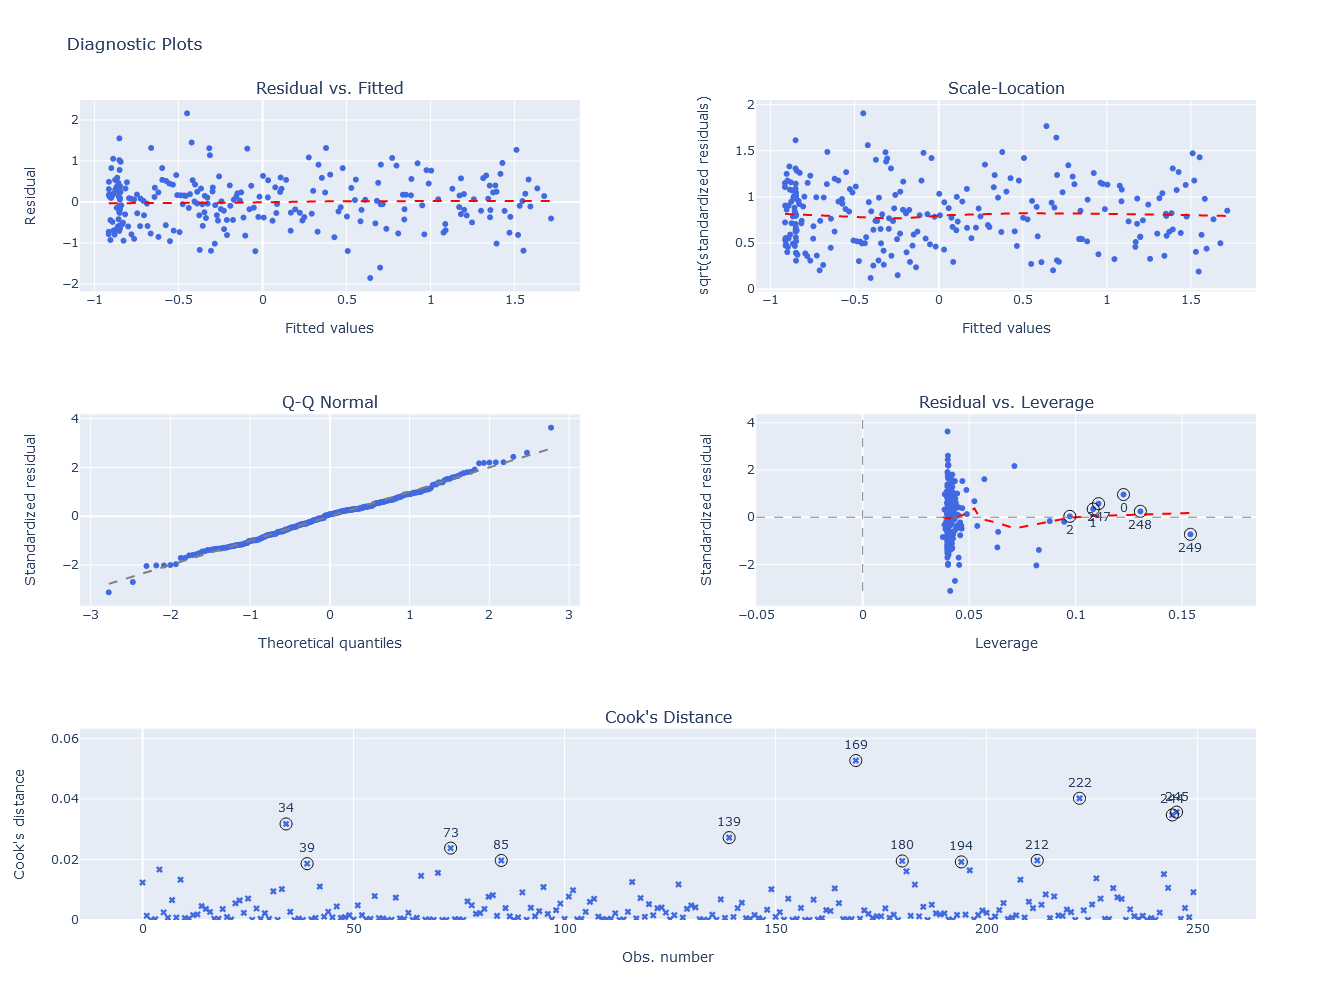

In [10]:
M1.plot_diagosticPlots(y=y)

# Extrapolation

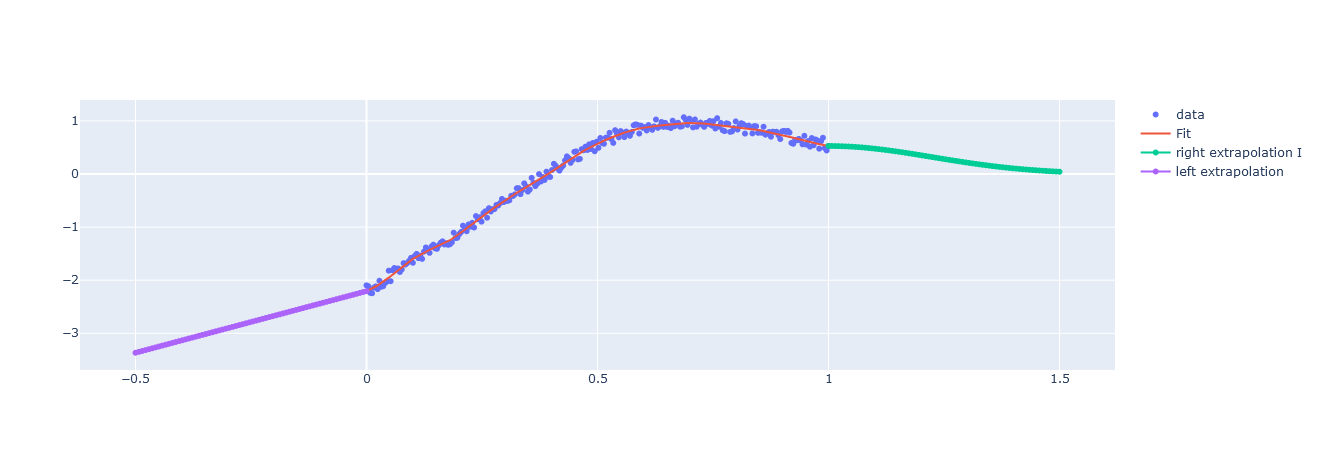

In [10]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from stareg import StarModel 
from stareg.bspline import Bspline
from scipy.stats import t

# test with different dataset
np.random.seed(41)
n_samples = 250
x = np.random.random(n_samples)
x.sort()
xmax, xmin = x.max(), x.min()
x = x
x = (x - xmin) / (xmax - xmin)

# test with linspace data
x = np.linspace(0,1,250)

noise = np.random.random(n_samples)
y_true = 2*np.exp(-(x - 0.4)**2 / 0.1) - 5.5*x**2 
y = y_true + noise*0.5
y = np.flip(y)
y = (y - y.mean()) / y.std()

n_param = 25
descr = ( ("s(1)", "peak", n_param, (0.1, 1000), "equidistant"), )
M = StarModel(description=descr)
M.fit(X=x.reshape(-1,1), y=y, plot_=False)

# extrapolation
x_right = np.linspace(1,1.5,70)
x_left = np.linspace(-0.5,0,70)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="data"))
fig.add_trace(go.Scatter(x=x, y=M.basis @ M.coef_, name="Fit"))
fig.add_trace(go.Scatter(x=x_right, y=M.predict(X=x_right, extrapol_type="zero", depth=10), mode="markers+lines", name="right extrapolation I "))
fig.add_trace(go.Scatter(x=x_left, y=M.predict(X=x_left, extrapol_type="linear", depth=1), mode="markers+lines", name="left extrapolation"))

## Confidence Interval as given in Fahrmeir, Regression 2013   ----- ONLY VALID FOR LINEAR MODELS 
the CI is given as follows: $\hat \beta_j \pm t_{n-p}(1-\alpha/2) se_j$ with  $se_j = \sqrt{\text{diag } \widehat{\text{Cov}(\hat \beta)}}$ with $\widehat{\text{Cov}(\hat \beta)} = \hat \sigma_{REML}^2 (X'X)^{-1} = \frac{1}{n-p} \hat \epsilon' \hat \epsilon (X'X)^{-1}$ True

## Prediction Interval as given in Fahrmeir, Regression 2013  ---- ONLY VALID FOR LINEAR MODELS

the PI for point $x_0$ that is given by the model maxtrix row $x_0'$ is given by: $ x_0'\hat \beta_j \pm t_{n-p}(1-\alpha/2) \hat \sigma (1 + x_0'(X'X)^{-1}x_0)^{1/2}$  with  $\hat \sigma^2 = \hat \sigma_{REML}^2 = \frac{1}{n-p} \hat \epsilon' \hat \epsilon$ 

## Confidence Intervals and Bands for Nonparametric Regression Models
- rework the prediction and confidence intervals for the non-parametric regression 
- all given in Fahrmeir, 8.1.8 "General Scatterplot Smoothing"
  - linear smoother property: $\hat f = S y$
  - need the hat matrix
  - Confidence intervals vs confidence bands
    - Intervals: narrower, hold only for the point they are calculated for - p. 470 - given by $\hat f(z) \pm z_{1-\alpha / 2} \sigma \sqrt{s(z)'s(z)}$ with $s(z)' = z'(Z'Z + \lambda K)^{-1}Z'$

In [22]:
from scipy.stats import norm

In [23]:
norm.ppf(1-0.025)

1.959963984540054

In [37]:
# calculate s(z)'
Z = M.basis
lambdaK =M.constraint_penalty_matrix
S = M.calc_hat_matrix()

def CI(x, Z=Z, lambdaK=lambdaK, S=S):
    
    y_p = M.predict(X=[x])
    
    m = norm.ppf(1-0.05/2)
    sigma_hat = np.sqrt(1 / (Z.shape[0] - np.trace(2*S - S @ S.T)) * Z.shape[0] * M.mse)
    
    z = [M.smooths[0].bspline(x=x, knots=M.smooths[0].knots, i=i, m=2) for i in range(len(M.coef_))]
    s = np.array(z).T @ np.linalg.inv(Z.T @ Z + lambdaK) @Z.T
    
    sqrt_sTs = np.sqrt(s.T @ s)
    y_m = y_p - m * sigma_hat * sqrt_sTs
    y_p = y_p + m * sigma_hat * sqrt_sTs
    
    return y_m, y_p

def CB_bonferroni(x, Z=Z, lambdaK=lambdaK, S=S):
    
    y_p = M.predict(X=x)
    
    m = norm.ppf(1-0.05/(2*len(x)))
    sigma_hat = np.sqrt(1 / (Z.shape[0] - np.trace(2*S - S @ S.T)) * Z.shape[0] * M.mse)
    
    z = np.empty((len(x), len(M.coef_)))
    for i in range(len(M.coef_)):
        z[:,i] = M.smooths[0].bspline(x=x, knots=M.smooths[0].knots, i=i, m=2)
    
    
    s = z @ np.linalg.inv(Z.T @ Z + lambdaK) @Z.T
    
    sqrt_sTs = np.sqrt(np.diag(s @ s.T))

    y_m = y_p - m * sigma_hat * sqrt_sTs
    y_p = y_p + m * sigma_hat * sqrt_sTs
    
    return y_m, y_p

#px.imshow(np.array(z).T @ np.linalg.inv(Z.T @ Z + lambdaK) @Z.T)


In [16]:
random_idx = np.random.choice(np.arange(len(x)), size=100)
random_idx.sort()
rx = x[random_idx]
ry = y[random_idx]

In [38]:
y_p, y_m = [], []
for i in x:
    ci = CI(x=i)
    y_m.append(ci[0][0])
    y_p.append(ci[1][0])
    
    

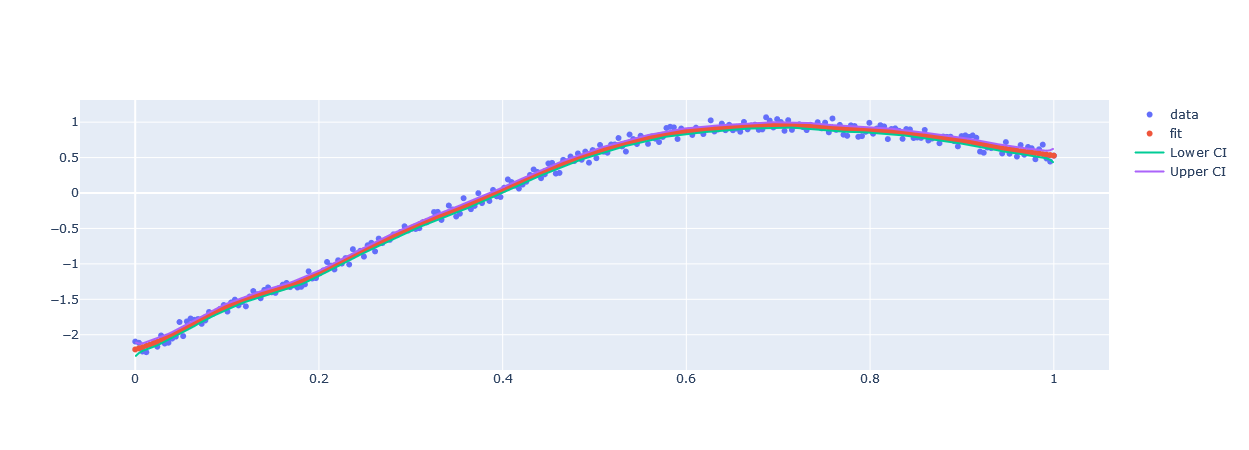

In [39]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="data"))
fig.add_trace(go.Scatter(x=x, y=M.basis @ M.coef_, mode="markers", name="fit"))
fig.add_trace(go.Scatter(x=x, y=y_m, mode="lines", name="Lower CI"))
fig.add_trace(go.Scatter(x=x, y=y_p, mode="lines", name="Upper CI"))
#fig.add_trace(go.Scatter(x=rx, y=CB_bonferroni(x=x)[0], mode="lines", name="lower CB"))
#fig.add_trace(go.Scatter(x=rx, y=CB_bonferroni(x=x)[1], mode="lines", name="upper CB"))

In [62]:
z = [M.smooths[0].bspline(x=0.1, knots=M.smooths[0].knots, i=i, m=2) for i in range(len(M.coef_))]
s = np.array(z).T @ np.linalg.inv(Z.T @ Z + lambdaK) @Z.T

In [65]:
s.T @ s

0.0943502458606199

Sigma^2= 0.6911869954593558


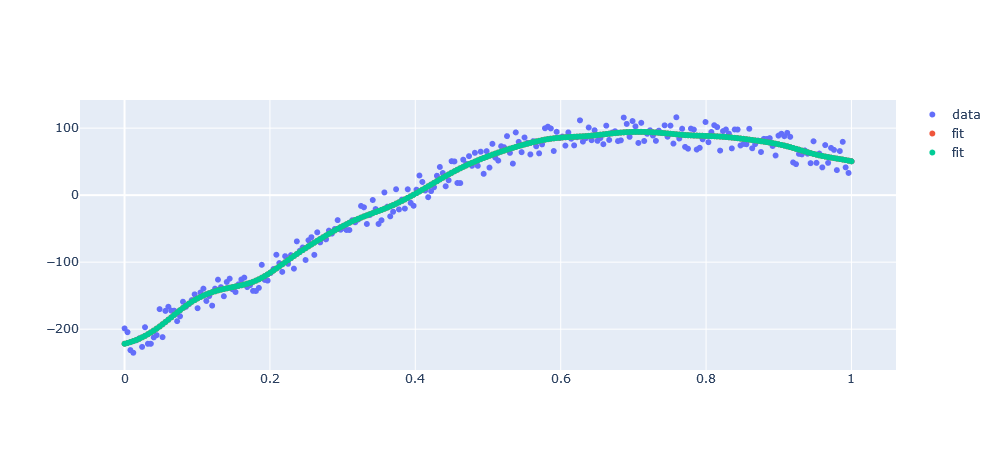

In [48]:
S = M.calc_hat_matrix()
dof_res = np.trace(2*S - S @ S.T)
n = M.basis.shape[0]
sigma_square_hat = 1 / (n - dof_res) * M.mse
print("Sigma^2=", sigma_square_hat)
m = norm.ppf(1-0.05/2)

y_pred = M.basis @ M.coef_


#fig.add_trace(go.Scatter(x=x, y=y_pred - m * np.sqrt(sigma_square_hat) * np.sqrt(np.diag(np.linalg.pinv(S @ S.T))) , mode="lines", name="lower CI"))
#fig.add_trace(go.Scatter(x=x, y=y_pred + m * np.sqrt(sigma_square_hat) * np.sqrt(np.diag(np.linalg.pinv(S @ S.T))) , mode="lines", name="upper CI"))




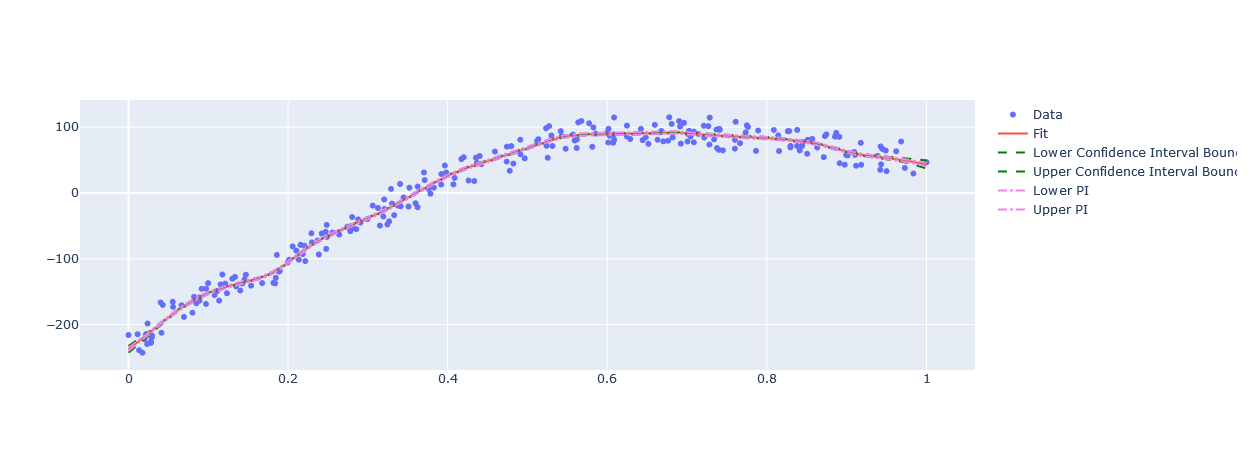

In [2]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x.ravel(), y=y.ravel(), mode="markers", name="Data"))
fig.add_trace(go.Scatter(x=x.ravel(), y=M.basis @ M.coef_, name="Fit"))
M.plot_confidence_intervals(fig=fig, x=x)
M.calc_prediction_interval(X=x, fig=fig)
fig.show()


# Multi-Peak

- [x] test if the "security" non-constraint splines (4 splines in the peak region are currently not constraint) in the peak and valley constraint are really needed for smooth function fitting.
        -> not needed, changed to only one non-constraint spline
- [x] implement multi-peak
- [x] implement multi-valley
- [x] implement peak-valley or other way
        -> basics work, but it needs polishing
- [ ] think of a way to specify multi-peak in the model description
- [ ] Testing !

**Test for  Multi Peak Data**

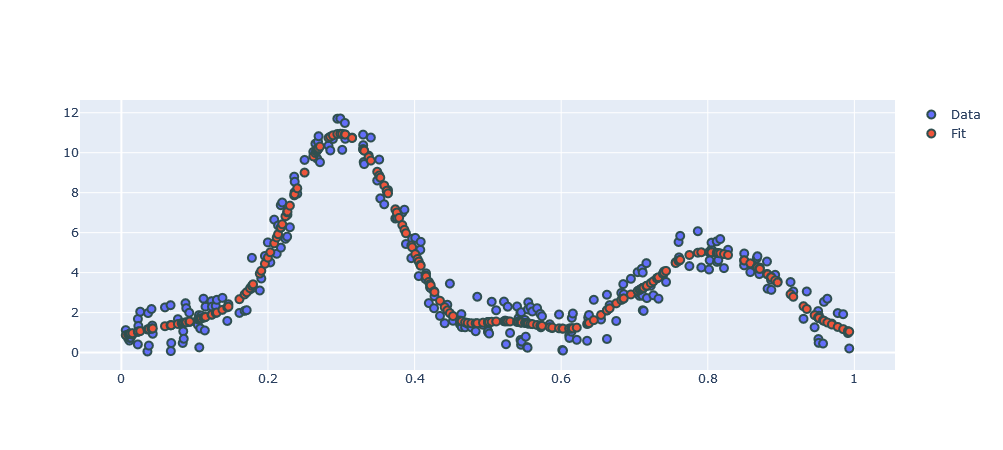

Violated Constraints: 2 from 25 


StarModel(s(1)={'constraint': 'multi-peak', 'knot_type': 'equidistant',
                'lam': {'constraint': 1000, 'smoothness': 0.1}, 'n_param': 25})

In [6]:
import numpy as np
from stareg.star_model import StarModel
x = np.random.random(250)
x.sort()
noise = np.random.random(250)*1.25
y_true = 10*np.exp(-(x-0.3)**2 / 0.01 ) + 4*np.exp(-(x-0.8)**2/0.01)
y = y_true + noise*2
n_param = 25
descr = ( ("s(1)", "multi-peak", n_param, (0.1, 1000), "equidistant"), )
M = StarModel(description=descr)
M.fit(X=x.reshape(-1,1), y=y, plot_=True)

**Test for Multi-Valley Data**

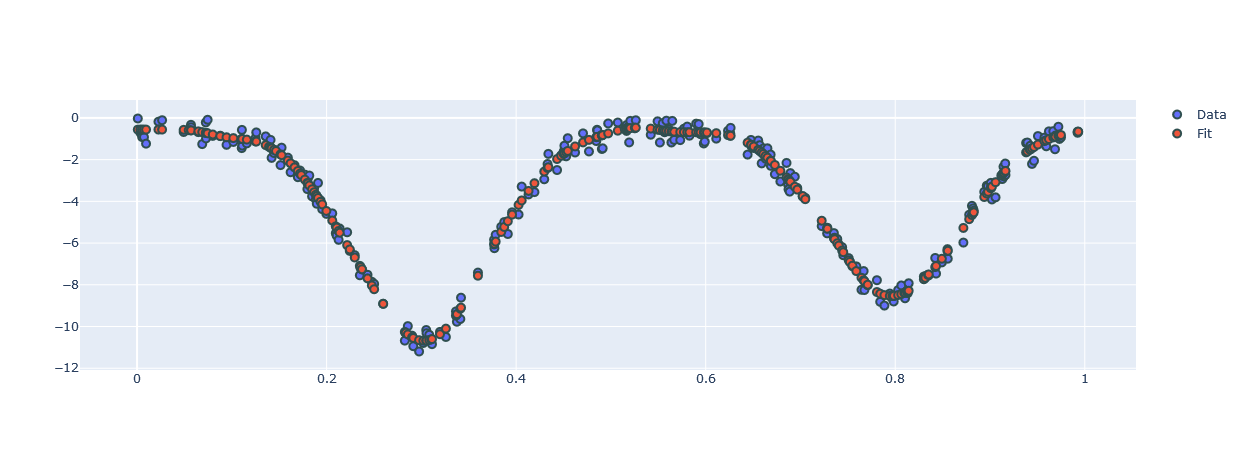

Violated Constraints: 4 from 35 


StarModel(s(1)={'constraint': 'multi-valley', 'knot_type': 'equidistant',
                'lam': {'constraint': 1200, 'smoothness': 0.1}, 'n_param': 35})

In [6]:
import numpy as np
from stareg.star_model import StarModel
x = np.random.random(250)
x.sort()
noise = np.random.random(250)*1.25
y = 10*np.exp(-(x-0.3)**2 / 0.01 ) + 8*np.exp(-(x-0.8)**2/0.01) + noise
y = -1*y
descr = ( ("s(1)", "multi-valley", 35, (0.1, 1200), "equidistant"), )
M = StarModel(description=descr)
M.fit(X=x.reshape(-1,1), y=y, plot_=True)

**Test for Peak-Valley Data**

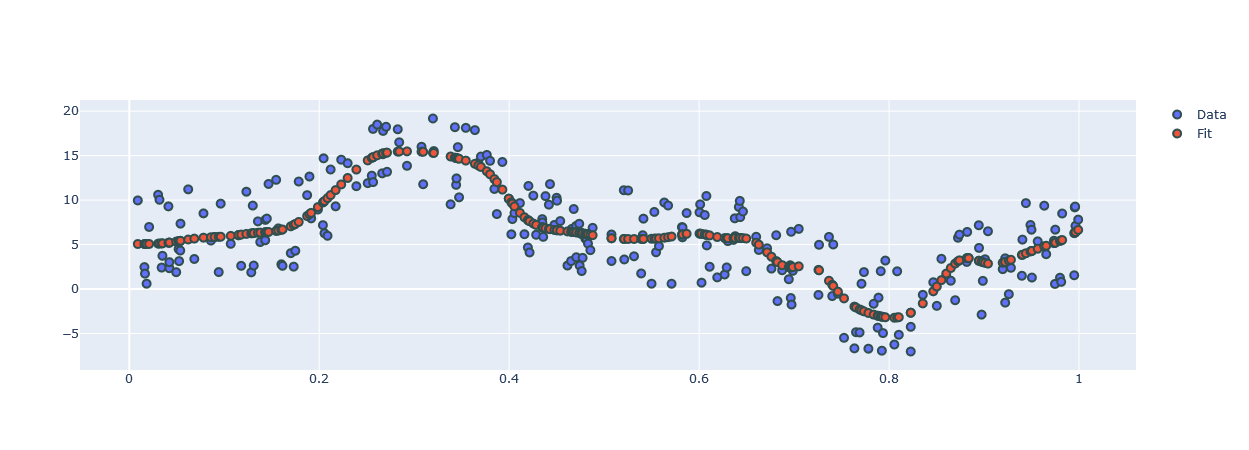

Violated Constraints: 9 from 35 


StarModel(s(1)={'constraint': 'peak-and-valley', 'knot_type': 'equidistant',
                'lam': {'constraint': 100, 'smoothness': 0.1}, 'n_param': 35})

In [8]:
import numpy as np
from stareg.star_model import StarModel
x = np.random.random(250)
x.sort()
noise = np.random.random(250)*2.25
y = 10*np.exp(-(x-0.3)**2 / 0.01 ) - 8*np.exp(-(x-0.8)**2/0.01) + 5*noise #+ 10*x
#px.scatter(x=x, y=y)
n_param = 35

descr = ( ("s(1)", "peak-and-valley", n_param, (0.1, 100), "equidistant"), )
M = StarModel(description=descr)
M.fit(X=x.reshape(-1,1), y=y, plot_=True)